In [1]:
# -*- coding:utf-8 -*-
import pandas as pd
import numpy as np
import networkx as nx
import jieba
from jieba import posseg as pseg
import matplotlib.pyplot as plt
%matplotlib inline
import pypinyin as pypy
from node2vec import Node2Vec
from scipy.spatial.distance import cosine
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

import torch
import torch.nn as nn
from  torch.nn import functional as F
import torch.optim as optim

# below is a context graph, that represents words that are adjencent to each other with count as weight

Building prefix dict from the default dictionary ...
Dumping model to file cache /tmp/jieba.cache
Loading model cost 0.611 seconds.
Prefix dict has been built succesfully.


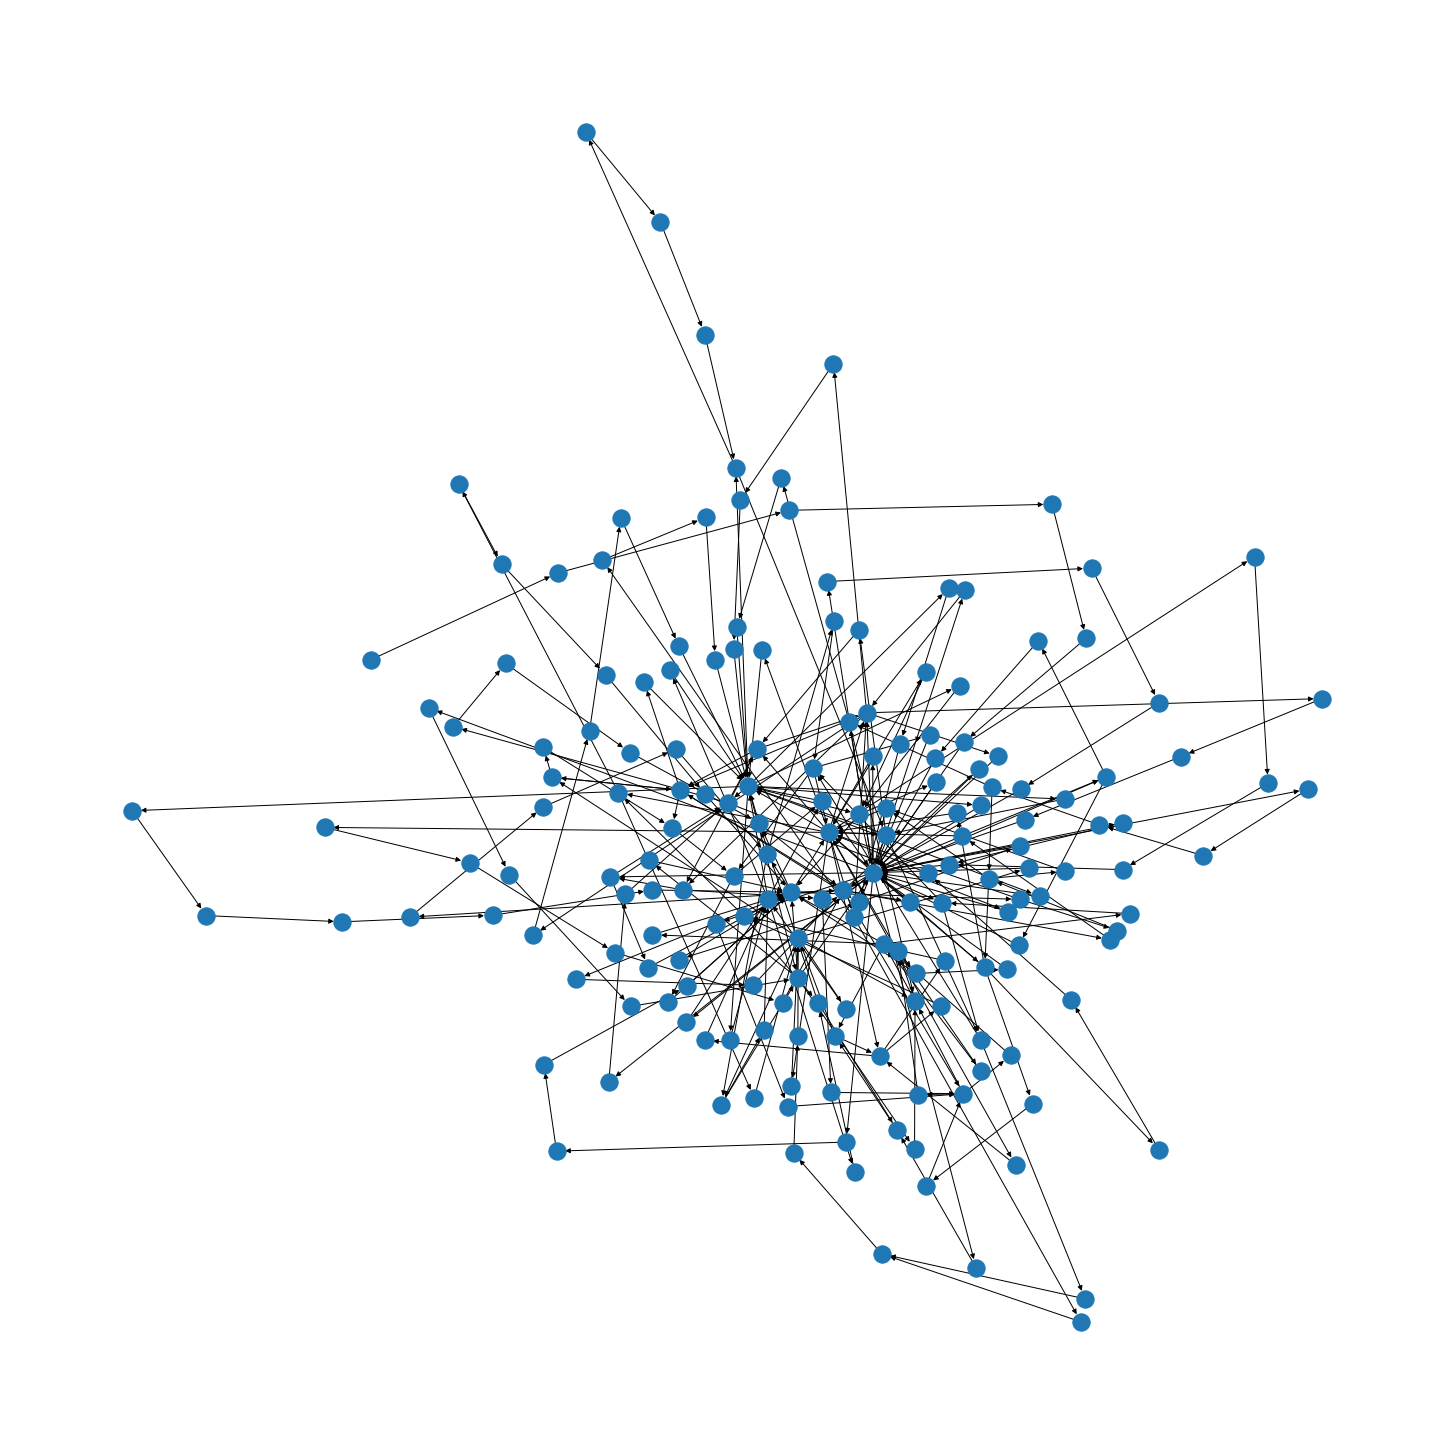

In [2]:
with open("data/data.txt","r") as f:
    data = f.readlines()
full_data = {}
title = None
word_pos = {}
for l in data:
    if l.startswith("#"):
        title = l.strip("#").strip("\n").strip()
        full_data[title]=[]
    else:
        if l!="\n":
            full_data[title].append([w for w,_ in pseg.lcut(l.strip("\n"))])
            for w,tag in pseg.lcut(l.strip("\n")):
                if title=="libra":
                    word_pos[w]=tag
data = full_data["libra"]
G =  nx.DiGraph()
for s in data:
    G.add_nodes_from(s)
    for i,w in enumerate(s[1:]):
        if (s[i],w) not in G.edges:
            G.add_edge(s[i],w,weight=1)
        else:
            G[s[i]][w]["weight"]+=1
plt.figure(figsize=(20,20))
nx.draw(G,with_label=True,font_weight="bold")
pd.Series(nx.pagerank(G)).sort_values(ascending=False)
left1 = {n:set() for n in G.nodes}
left2 = {n:set() for n in G.nodes}
right1 = {n:set() for n in G.nodes}
right2 = {n:set() for n in G.nodes}
for n in G.nodes:
    for l1 in G.predecessors(n):
        left1[n]|=set([l1])
        left2[n]|=set([l1])
        for l2 in G.predecessors(l1):
            left2[n]|=set([l2])
    for r1 in G.successors(n):
        right1[n]|=set([r1])
        right2[n]|=set([r1])
        for r2 in G.successors(r1):
            right2[n]|=set([r2])
context1 = {n:set() for n in G.nodes}
context2 = {n:set() for n in G.nodes}
for w in context1.keys():
    context1[w] = left1[w]|right1[w]
    context2[w] = left2[w]|right2[w]

In [3]:
set(list(G.nodes()))-set(word_pos.keys())

set()

# the words similarity are calculated with jaccard index on the target word context, meaning words appear next to the target word.

In [4]:
similarity_matrix = pd.DataFrame(data=np.zeros((len(context1.keys()),len(context1.keys()))),index=list(context1.keys()),columns=list(context1.keys()))
for row in similarity_matrix.index:
    for col in similarity_matrix.columns:
        if row!=col:
            similarity_matrix.loc[row,col]=len(context1[row]&context1[col])/len(context1[row]|context1[col])
print("below are the found similar words with window size 1, left1 and right1")
for i,row in enumerate(similarity_matrix.index):
    for j,col in enumerate(similarity_matrix.columns):
        if i>j:
            if similarity_matrix.loc[row,col]>0.5:
                print(row,col,similarity_matrix.loc[row,col])

below are the found similar words with window size 1, left1 and right1
日内瓦 瑞士 1.0
阻止 要求 1.0
都 上线 1.0
管制 数字 1.0
提问 事实 1.0
称 表示 1.0


In [5]:
similarity_matrix = pd.DataFrame(data=np.zeros((len(context2.keys()),len(context2.keys()))),index=list(context2.keys()),columns=list(context2.keys()))
for row in similarity_matrix.index:
    for col in similarity_matrix.columns:
        if row!=col:
            similarity_matrix.loc[row,col]=len(context2[row]&context2[col])/len(context2[row]|context2[col])
print("below are the found similar words with window size 2, left2 and right2")
for i,row in enumerate(similarity_matrix.index):
    for j,col in enumerate(similarity_matrix.columns):
        if i>j:
            if similarity_matrix.loc[row,col]>0.9:
                print(row,col,similarity_matrix.loc[row,col])

below are the found similar words with window size 2, left2 and right2
日内瓦 瑞士 1.0
提问 事实 1.0
称 表示 1.0
需要 据 0.9166666666666666
需要 今天 0.9166666666666666
需要 那么 0.9166666666666666
需要 但 0.9166666666666666
需要 对 0.9166666666666666
现在 需要 0.9166666666666666
透露 日讯 0.9090909090909091
透露 报道 0.9090909090909091
透露 中 0.9090909090909091
透露 强调 0.9523809523809523
透露 上线 0.9090909090909091
透露 时 0.9090909090909091
手续费 透露 0.9090909090909091
具体 需要 0.9166666666666666


# node2vec is the graph equivalent of word2vec. The difference is that I run the algorithm on the same word context graph as the above wordrep.

In [6]:
node2vec = Node2Vec(G, dimensions=32, walk_length=30, num_walks=200, workers=4)
model = node2vec.fit(window=10, min_count=1, batch_words=4)

Computing transition probabilities: 100%|██████████| 181/181 [00:00<00:00, 13659.28it/s]


In [7]:
G.nodes

NodeView(('PingWest', '品玩', '7', '月', '18', '日讯', '，', '据', '新浪', '科技', '报道', '今天', '美国众议院', '金融服务', '委员会', '针对', 'Facebook', ' ', 'Libra', '举行', '听证会', '所', '担心', '的', '问题', '向', '项目', '负责人', '大卫', '·', '马库斯', '（', 'David', 'Marcus', '）', '发问', '。', '这', '也', '是', '面临', '第二场', '议员', '询问', '第三方', '钱包', '是否', '可以', '整合', '入', 'WhatsApp', '和', 'Messenger', '中', '没有', '正面', '回应', '一', '综合', '昨日', '与', '美国参议院', '证词', '可能', '无法', '“', '如果', '你们', '要', '支付宝', '微信', '支付', '竞争', '那么', '为何', '在', '瑞士', '注册', '？', '篮子', '货币', '挂钩', '”', '默认', '了', '将', '、', '事实', '同时', '再次', '强调', '日内瓦', '不是', '为了', '逃避', '美国', '监管', '表示', '证券', 'ETF', '它', '商品', '但', '我们', '希望', '工具', '不会', '主权', '行使主权', '职责', '显然', '更', '适合', '央行', '对于', '愿意', '遵守', '美国财政部', '制裁', '要求', '并', '阻止', '无论', '会', '上线', '都', '有', '其他', '网络', '出现', '对', '许多', '国家', '来说', '成为', '一种', '非常', '高质量', '数字', '众议院', '如何', '具有', '管制', '/', '地区', '运行', '提问', '称', '不同', '方法', 'Blaine', '发展', '成', '什么样', '金融', '或', '银行', '服务', '需要', '时', '加密', '

In [245]:
def compare_words(w1,w2,model=model):
    return cosine(model.wv.get_vector(w1),model.wv.get_vector(w2))
def get_top_similar_words(w,words,k=5,model=model):
    distances = []
    for tw in words:
        if tw!=w:
            distances.append([tw,compare_words(w,tw)])
    results = pd.DataFrame(data=distances,columns=["top_{}_words".format(k),"scores"])
    return results.sort_values(["scores"])[:k]

# as we can see the two location words come very close to each other.

In [246]:
compare_words("日内瓦","瑞士")

0.0017662644386291504

# and the top5 words for 表示 makes some sense too

In [249]:
get_top_similar_words('日内瓦',list(G.nodes))

,top_5_words,scores
76,瑞士,0.001766
140,具有,0.465970
81,挂钩,0.651689
51,和,0.708409
90,强调,0.744496


# gcn untrained
这一部分使用未训练的gcn来得到词嵌入。因为原文里边使用未训练的gcn在跆拳道俱乐部图上得到了已经开始聚合的图嵌入。所以这个地方我也想使用未训练的gcn来得到词嵌入。因为没有训练，所以对结果期待不高。

In [12]:
indeces = list(G.nodes)

In [254]:
def gcn_layer(dad,inputs,dims=len(G.nodes())):
    """
    一个gcn层，提前算好的D*A*D（DAD）。
    """
    params = np.random.random(size=(dims,dims))
    outputs = dad.dot(inputs).dot(params)
    return outputs
def gcn_embed(n_gcn=2):
    """
    gcn模型，先计算了DAD。初始的输入为单位矩阵。
    """
    np.random.seed(0)
    adj = nx.adjacency_matrix(G,G.nodes()).toarray()
    adj = adj+np.eye(adj.shape[0])
    dad = adj.dot(np.diag(np.power(adj.sum(1),-0.5))).T.dot(np.diag(np.power(adj.sum(1),-0.5)))
    #inputs = np.ones((dad.shape[0],50))
    #inputs = np.random.random((dad.shape[0],50))
    inputs = np.diag(np.ones(len(G.nodes())))
    for _ in range(n_gcn):
        inputs = gcn_layer(dad,inputs)
    return inputs
def get_gcn_embedding(n_gcn,indeces=indeces):
    """
    一个获取gcn词嵌入的帮助函数。
    """
    embeddings = gcn_embed(n_gcn)
    gcn_embeddings = {}
    for i,e in zip(indeces,embeddings):
        gcn_embeddings[i]=e
    return gcn_embeddings
def compare_words(w1,w2,embeddings):
    """
    一个就是余弦距离的帮助函数。
    """
    return (cosine(embeddings[w1],embeddings[w2])+1)/2
def get_top_similar_words(w,embeddings,k=5,reverse=False):
    """
    一个计算前多少个最相近词的帮助函数。
    """
    distances = []
    for tw in embeddings.keys():
        if tw!=w:
            distances.append([tw,compare_words(w,tw,embeddings)])
    results = pd.DataFrame(data=distances,columns=["top_{}_words".format(k),"scores"])
    if reverse:
        return results.sort_values(["scores"])[-k:]
    return results.sort_values(["scores"])[:k]

In [234]:
gcn_embeddings = get_gcn_embedding(5,indeces)

In [235]:
compare_words("表示","称",gcn_embeddings)

0.500000000000002

In [243]:
get_top_similar_words("日内瓦",gcn_embeddings,k=5)

,top_5_words,scores
76,瑞士,0.5
140,具有,0.5
139,如何,0.5
75,在,0.5
40,面临,0.5


# training gcn with jieba pos

## prepare data

In [338]:
outputs = [word_pos[w] for w in list(G.nodes())]
o2id = {o:i for i,o in enumerate(set(outputs))}
outputs = [o2id[o] for o in outputs]

In [339]:
class GCN_EMBEDDER(nn.Module):
    def __init__(self,G,vocab_size,embedding_size,output_size,n_gcn):
        super(GCN_EMBEDDER,self).__init__()
        adj = nx.adjacency_matrix(G,G.nodes()).toarray()
        adj = adj+np.eye(adj.shape[0])
        adj = adj.dot(np.diag(np.power(adj.sum(1),-0.5))).T.dot(np.diag(np.power(adj.sum(1),-0.5)))
        self.adj = torch.FloatTensor(adj)
        self.gcn_params = [nn.Linear(embedding_size,embedding_size) for _ in range(n_gcn)]
        self.projection = nn.Linear(embedding_size,output_size)
        self.embedding_size = embedding_size
        self.relu = F.relu
        self.dropout = nn.Dropout(0.1)
        self.norm = nn.BatchNorm1d(embedding_size)
        self.input_embedder = nn.Embedding(vocab_size,embedding_size)
    
    def gcn_layer(self,inputs):
        return torch.matmul(self.adj,inputs)
    def embed(self,inputs):
        inputs = self.input_embedder(inputs)
        for l in self.gcn_params:
            inputs = l(self.norm(self.relu(self.gcn_layer(inputs))))
        return inputs
    def forward(self,inputs):
        out = self.embed(inputs)
        out = self.relu(self.projection(out))
        log_probs = F.log_softmax(out,dim=1)
        return log_probs

In [340]:
words = list(G.nodes)
np.random.shuffle(words)
w2id = {w:i for i,w in enumerate(words)}
id2w = {i:w for i,w in enumerate(words)}

In [356]:
def train_gcn_embedder(n_gcn=2,epochs=10):
    torch.manual_seed(1)
    np.random.seed(1)
    gcn_embedder = GCN_EMBEDDER(G,len(G.nodes),50,len(set(outputs)),n_gcn)
    losses = []
    loss_function = nn.NLLLoss()
    optimizer = optim.Adam(gcn_embedder.parameters(),lr=0.001)
    
    for e in range(epochs):
        inputs = torch.LongTensor([w2id[w] for w in list(G.nodes)])
        out = gcn_embedder(inputs)
        loss = loss_function(out,torch.LongTensor(outputs))
        losses.append(float(loss.data.numpy()))
        loss.backward()
        optimizer.step()
        if e%31==0:
            print("epoch {} has loss {:.2f}".format(e,loss))
    indeces = list(G.nodes)
    gcn_embeddings = {}
    for i,e in zip(indeces,gcn_embedder.embed(torch.LongTensor([w2id[w] for w in list(G.nodes)])).data.numpy()):
        gcn_embeddings[i]=e
    pd.Series(losses).plot();
    return gcn_embeddings,losses,gcn_embedder

epoch 0 has loss 3.14
epoch 31 has loss 2.94
epoch 62 has loss 2.70
epoch 93 has loss 2.40
epoch 124 has loss 2.09
epoch 155 has loss 1.81
epoch 186 has loss 1.55
epoch 217 has loss 1.32
epoch 248 has loss 1.12
epoch 279 has loss 0.96
epoch 310 has loss 0.84
epoch 341 has loss 0.73
epoch 372 has loss 0.64
epoch 403 has loss 0.55
epoch 434 has loss 0.48
epoch 465 has loss 0.43
epoch 496 has loss 0.36
epoch 527 has loss 0.32
epoch 558 has loss 0.29
epoch 589 has loss 0.27
epoch 620 has loss 0.25
epoch 651 has loss 0.24
epoch 682 has loss 0.23
epoch 713 has loss 0.22
epoch 744 has loss 0.21
epoch 775 has loss 0.21
epoch 806 has loss 0.21
epoch 837 has loss 0.20
epoch 868 has loss 0.19
epoch 899 has loss 0.20
epoch 930 has loss 0.20
epoch 961 has loss 0.20
epoch 992 has loss 0.19


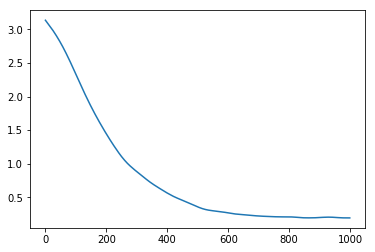

In [360]:
gcn_embeddings,losses,gcn_embedder = train_gcn_embedder(epochs=1000)

In [361]:
compare_words("表示","称",gcn_embeddings)

0.6277064681053162

In [362]:
get_top_similar_words("表示",gcn_embeddings)

,top_5_words,scores
146,称,0.627706
83,默认,0.650872
49,入,0.662318
121,无论,0.673443
66,如果,0.686127


# 验证了一下adj矩阵行不行。

In [211]:
indeces = list(G.nodes)
gcn_embeddings = {}
for i,e in zip(indeces,gcn_embedder.adj.data.numpy()):
    gcn_embeddings[i]=e

In [212]:
compare_words("表示","称",gcn_embeddings)

0.8161186724901199

In [213]:
get_top_similar_words("日内瓦",gcn_embeddings,k=5)

,top_5_words,scores
77,注册,0.750000
140,具有,0.833333
76,瑞士,0.833333
75,在,0.859729
0,PingWest,1.000000


# training gcn on a skip-gram setting

In [364]:
context1_ids = {}
for k in context1.keys():
    context1_ids[k] = [w2id[w] for w in context1[k]]
def spit_context(w,contexts):
    return np.random.choice(contexts[w])

In [365]:
def train_gcn_embedder(n_gcn=2,epochs=10,batchs=3):
    torch.manual_seed(0)
    np.random.seed(0)
    nodes = list(G.nodes())
    gcn_embedder = GCN_EMBEDDER(G,len(G.nodes),300,len(nodes),n_gcn)
    losses = []
    loss_function = nn.NLLLoss()
    optimizer = optim.Adam(gcn_embedder.parameters(),lr=0.001)
    for e in range(epochs):
        for b in range(batchs):
            outputs = [spit_context(w,context1_ids) for w in nodes]
            inputs = torch.LongTensor([w2id[w] for w in nodes])
            gcn_embedder.zero_grad()
            out = gcn_embedder(inputs)
            loss = loss_function(out,torch.LongTensor(outputs))
            losses.append(float(loss.data.numpy()))
            loss.backward()
            optimizer.step()
        if e%7==0:
            print("epoch {} has loss {:.2f}".format(e,loss))
    indeces = list(G.nodes)
    gcn_embeddings = {}
    for i,e in zip(indeces,gcn_embedder(inputs).data.numpy()):
        gcn_embeddings[i]=e
    pd.Series(losses).plot();
    return gcn_embeddings,losses,gcn_embedder

epoch 0 has loss 5.17
epoch 7 has loss 4.72
epoch 14 has loss 4.14
epoch 21 has loss 3.51
epoch 28 has loss 3.20
epoch 35 has loss 3.02
epoch 42 has loss 2.71
epoch 49 has loss 2.55
epoch 56 has loss 2.41
epoch 63 has loss 2.40
epoch 70 has loss 2.51
epoch 77 has loss 2.30
epoch 84 has loss 2.20
epoch 91 has loss 2.00
epoch 98 has loss 2.40
epoch 105 has loss 2.09
epoch 112 has loss 2.37
epoch 119 has loss 2.35
epoch 126 has loss 2.15
epoch 133 has loss 2.12
epoch 140 has loss 2.14
epoch 147 has loss 2.07


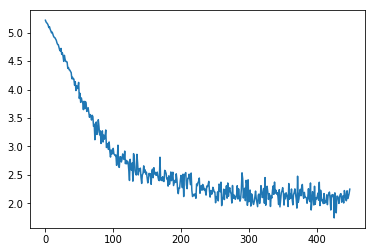

In [366]:
gcn_embeddings,losses,gcn_embedder = train_gcn_embedder(n_gcn=2,epochs=150)

In [367]:
compare_words("表示","称",gcn_embeddings)

0.500415027141571

In [369]:
get_top_similar_words("表示",gcn_embeddings,k=5)

,top_5_words,scores
146,称,0.500415
88,同时,0.501201
83,默认,0.501223
54,没有,0.501387
29,·,0.502187


# build GCN layerwise jieba tag

In [370]:
class GC_Layer(nn.Module):
    def __init__(self,G,input_size,output_size):
        super(GC_Layer,self).__init__()
        adj = nx.adjacency_matrix(G,G.nodes()).toarray()
        adj = adj+np.eye(adj.shape[0])
        adj = adj.dot(np.diag(np.power(adj.sum(1),-0.5))).T.dot(np.diag(np.power(adj.sum(1),-0.5)))
        self.adj = torch.FloatTensor(adj)
        self.project = nn.Linear(input_size,output_size)
        
    def agg(self,inputs):
        return torch.mm(self.adj,inputs)
    def forward(self,inputs):
        agged = self.agg(inputs)
        projected = self.project(agged)
        return projected

In [371]:
class GCN_Embedder(nn.Module):
    def __init__(self,G,hidden_gc_dim,gc_out_dim,n_classes):
        super(GCN_Embedder,self).__init__()
        self.gc_1 = GC_Layer(G,len(G.nodes()),hidden_gc_dim)
        self.gc_2 = GC_Layer(G,hidden_gc_dim,gc_out_dim)
        self.project = nn.Linear(gc_out_dim,n_classes)
        self.norm = nn.BatchNorm1d(gc_out_dim)
        
    def embed(self,inputs):
        inputs = self.gc_1(inputs)
        return self.gc_2(inputs)
    def forward(self,inputs):
        inputs = self.embed(inputs)
        out = self.project(self.norm(inputs))
        return F.log_softmax(out,dim=1)

In [372]:
def train_gcn_embedder(epochs=10):
    torch.manual_seed(0)
    np.random.seed(0)
    gcn_embedder = GCN_Embedder(G,100,50,len(set(outputs)))
    losses = []
    loss_function = nn.NLLLoss()
    optimizer = optim.Adam(gcn_embedder.parameters(),lr=0.001)
    
    for e in range(epochs):
        inputs = torch.eye(len(G.nodes()))
        out = gcn_embedder(inputs)
        loss = loss_function(out,torch.LongTensor(outputs))
        losses.append(float(loss.data.numpy()))
        loss.backward()
        optimizer.step()
        if e%31==0:
            print("epoch {} has loss {:.2f}".format(e,loss))
    indeces = list(G.nodes)
    gcn_embeddings = {}
    for i,e in zip(indeces,gcn_embedder.embed(torch.eye(len(G.nodes()))).data.numpy()):
        gcn_embeddings[i]=e
    pd.Series(losses).plot();
    return gcn_embeddings,losses,gcn_embedder

epoch 0 has loss 3.24
epoch 31 has loss 1.74
epoch 62 has loss 1.02
epoch 93 has loss 0.56
epoch 124 has loss 0.27
epoch 155 has loss 0.17
epoch 186 has loss 0.14
epoch 217 has loss 0.11
epoch 248 has loss 0.08
epoch 279 has loss 0.09
epoch 310 has loss 0.03
epoch 341 has loss 0.07


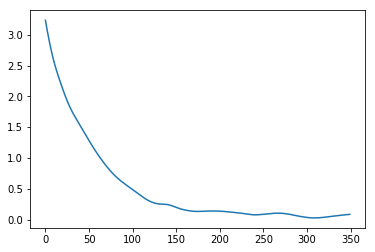

In [373]:
gcn_embeddings,losses,gcn_embedder = train_gcn_embedder(epochs=350)

In [374]:
compare_words("表示","称",gcn_embeddings)

0.5714088380336761

In [375]:
get_top_similar_words("表示",gcn_embeddings,k=5)

,top_5_words,scores
146,称,0.571409
51,和,0.586082
83,默认,0.588989
35,发问,0.595599
157,需要,0.596417


# skip_gram

In [376]:
def train_gcn_embedder(epochs=10):
    torch.manual_seed(0)
    np.random.seed(0)
    gcn_embedder = GCN_Embedder(G,100,50,len(G.nodes()))
    losses = []
    loss_function = nn.NLLLoss()
    optimizer = optim.Adam(gcn_embedder.parameters(),lr=0.001)
    nodes = list(G.nodes())
    for e in range(epochs):
        inputs = torch.eye(len(G.nodes()))
        outputs = [spit_context(w,context1_ids) for w in nodes]
        out = gcn_embedder(inputs)
        loss = loss_function(out,torch.LongTensor(outputs))
        losses.append(float(loss.data.numpy()))
        loss.backward()
        optimizer.step()
        if e%31==0:
            print("epoch {} has loss {:.2f}".format(e,loss))
    indeces = list(G.nodes)
    gcn_embeddings = {}
    for i,e in zip(indeces,gcn_embedder.embed(torch.eye(len(G.nodes()))).data.numpy()):
        gcn_embeddings[i]=e
    pd.Series(losses).plot();
    return gcn_embeddings,losses,gcn_embedder

epoch 0 has loss 5.27
epoch 31 has loss 4.25
epoch 62 has loss 3.55
epoch 93 has loss 2.74
epoch 124 has loss 2.23
epoch 155 has loss 1.96
epoch 186 has loss 1.81


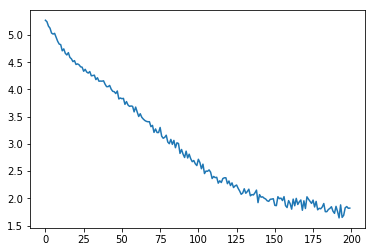

In [383]:
gcn_embeddings,losses,gcn_embedder = train_gcn_embedder(epochs=200)

In [384]:
compare_words("表示","称",gcn_embeddings)

0.5088319480419159

In [385]:
get_top_similar_words("表示",gcn_embeddings,k=5)

,top_5_words,scores
146,称,0.508832
54,没有,0.521774
30,马库斯,0.526738
83,默认,0.534633
59,昨日,0.537473


# build GAT

In [3]:
class Gat(nn.Module):
    def __init__(self,g,heads,hidden_dim,hidden_dim1,out_dim,mean_pool):
        super(Gat,self).__init__()
        self.g = g
        self.adj = nx.adjacency_matrix(g,g.nodes())
        srcs,tgts = self.adj.nonzero()
        neighbors = {i:[] for i in range(self.adj.shape[0])}
        neighbor_targets = {i:[] for i in range(self.adj.shape[0])}
        self.node_size = len(g.nodes())
        for i,j,t in zip(srcs,range(len(srcs)),tgts):
            neighbors[i].append(j)
            neighbor_targets[i].append(t)
        self.neighbors = neighbors
        self.neighbor_targets = neighbor_targets
        self.neighbor_pairs = [(i,j) for i,j in zip(srcs,tgts)]
        self.projector0s = [nn.Linear(self.node_size,hidden_dim,bias=False)
                           for _ in range(heads)]
        self.projector1s = [nn.Linear(2*hidden_dim,1,bias=False)
                           for _ in range(heads)]
        self.softmax = F.softmax
        self.leakyRelu = F.leaky_relu
        self.elu = F.elu
        self.relu = F.relu
        self.embedder_layers = [self.embedder_layer(p0,p1) for p0,p1 in 
                               zip(self.projector0s,self.projector1s)]
        self.projector0_out = nn.Linear(hidden_dim*heads,hidden_dim1,bias=False)
        self.projector1_out = nn.Linear(2*hidden_dim1,1)
        self.embedder_out = self.embedder_layer(self.projector0_out,self.projector1_out)
        self.output_projector = nn.Linear(hidden_dim1,out_dim)
    def stack_concate_neighbor_pairs(self,nodes):
        results = []
        for i,j in self.neighbor_pairs:
            results.append(torch.cat([nodes[i],nodes[j]]))
        return torch.stack(results)
    
    def get_weights_and_embeddings_blocks_for_i(self,i,nodes,pairs):
        return nodes[self.neighbor_targets[i]],pairs[self.neighbors[i]]
    
    def embedder_layer(self,projector0,projector1):
        def embed(nodes):
            #nodes = torch.eye(self.node_size)
            nodes = projector0(nodes)
            pairs = self.stack_concate_neighbor_pairs(nodes)
            pairs = projector1(pairs)
            pairs = self.leakyRelu(pairs)
            output_nodes = []
            for i in range(self.node_size):
                ith_weights,ith_embeddings = self.get_weights_and_embeddings_blocks_for_i(i,nodes,pairs)
                ith_weights = self.softmax(ith_weights)
                ith_weights = ith_weights.transpose(1,0)
                ith_nodes = torch.matmul(ith_weights,ith_embeddings)
                output_nodes.append(ith_nodes)
            return torch.squeeze(torch.stack(output_nodes))
        return embed
    def encode(self):
        nodes = torch.eye(self.node_size)
        embedded_nodes = []
        for el in self.embedder_layers:
            embedded_nodes.append(el(nodes))
        if mean_pool:
            embedded_nodes = torch.stack(embedded_nodes)
            embedded_nodes = torch.mean(embedded_nodes,dim=0)
            output_nodes = self.elu(embedded_nodes)
        else:
            embedded_nodes = torch.cat(embedded_nodes,dim=1)
            embedded_nodes = self.elu(embedded_nodes)
            output_nodes = self.embedder_out(embedded_nodes)
        return output_nodes
    def flow(self):
        output_nodes = self.encode()
        outputs = self.output_projector(output_nodes)
        outputs = self.relu(outputs)
        log_probs = F.log_softmax(outputs,dim=1)
        return log_probs

# GAT with jieba pos prediction task

In [4]:
outputs = [word_pos[w] for w in list(G.nodes())]
o2id = {o:i for i,o in enumerate(set(outputs))}
outputs = [o2id[o] for o in outputs]

In [29]:
def train_gat_embedder(g,heads,hidden_dim,hidden_dim1,out_dim,mean_pool,epochs,lr=0.001):
    torch.manual_seed(1)
    np.random.seed(1)
    gat_embedder = Gat(g,heads,hidden_dim,hidden_dim1,out_dim,mean_pool)
    losses = []
    loss_function = nn.NLLLoss()
    optimizer = optim.Adam(gat_embedder.parameters(),lr=lr)
    
    for e in range(epochs):
        gat_embedder.zero_grad()
        out = gat_embedder.flow()
        loss = loss_function(out,torch.LongTensor(outputs))
        losses.append(float(loss.data.numpy()))
        loss.backward()
        optimizer.step()
        if e%31==0:
            print("epoch {} has loss {:.2f}".format(e,loss))
    indeces = list(G.nodes)
    gat_embeddings = get_embedding_dict(gat_embedder.encode().detach().numpy(),indeces)
    pd.Series(losses).plot();
    return gat_embeddings,losses,gat_embedder

In [8]:
# helper funcs
def get_embedding_dict(embeddings,indeces):
    """
    一个获取gcn词嵌入的帮助函数。
    """
    out_embeddings = {}
    for i,e in zip(indeces,embeddings):
        out_embeddings[i]=e
    return out_embeddings
def compare_words(w1,w2,embeddings):
    """
    一个就是余弦距离的帮助函数。
    """
    return (cosine(embeddings[w1],embeddings[w2])+1)/2
def get_top_similar_words(w,embeddings,k=5,reverse=False):
    """
    一个计算前多少个最相近词的帮助函数。
    """
    distances = []
    for tw in embeddings.keys():
        if tw!=w:
            distances.append([tw,compare_words(w,tw,embeddings)])
    results = pd.DataFrame(data=distances,columns=["top_{}_words".format(k),"scores"])
    if reverse:
        return results.sort_values(["scores"])[-k:]
    return results.sort_values(["scores"])[:k]

epoch 0 has loss 3.16
epoch 31 has loss 3.15
epoch 62 has loss 3.14
epoch 93 has loss 3.14


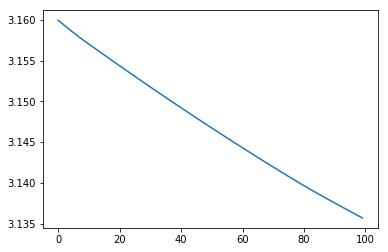

In [30]:
g = G
heads = 1
hidden_dim = 50
hidden_dim1 = 50
out_dim = len(set(outputs))
mean_pool = True
epochs = 100
lr = 0.001
gat_embeddings,lossses,gat_embedder = train_gat_embedder(g,heads,hidden_dim,hidden_dim1,out_dim,mean_pool,epochs,lr)

In [31]:
compare_words("瑞士","日内瓦",gat_embeddings)

0.4999999403953552

In [33]:
get_top_similar_words("表示",gat_embeddings)

,top_5_words,scores
146,称,0.5
62,证词,0.5
132,来说,0.5
161,合作,0.5
175,手续费,0.5


# train GAT with skip-gram setting

In [15]:
words = list(G.nodes)
np.random.shuffle(words)
w2id = {w:i for i,w in enumerate(words)}
id2w = {i:w for i,w in enumerate(words)}
context1_ids = {}
for k in context1.keys():
    context1_ids[k] = [w2id[w] for w in context1[k]]
def spit_context(w,contexts):
    return np.random.choice(contexts[w])

In [21]:
def train_gat_embedder(g,heads,hidden_dim,hidden_dim1,out_dim,mean_pool,epochs,batchs,lr=0.001):
    torch.manual_seed(1)
    np.random.seed(1)
    nodes = list(G.nodes())
    gat_embedder = Gat(g,heads,hidden_dim,hidden_dim1,out_dim,mean_pool)
    losses = []
    loss_function = nn.NLLLoss()
    optimizer = optim.Adam(gat_embedder.parameters(),lr=lr)
    
    for e in range(epochs):
        for b in range(batchs):
            outputs = [spit_context(w,context1_ids) for w in nodes]
            gat_embedder.zero_grad()
            out = gat_embedder.flow()
            loss = loss_function(out,torch.LongTensor(outputs))
            losses.append(float(loss.data.numpy()))
            loss.backward()
            optimizer.step()
        if e%7==0:
            print("epoch {} has loss {:.2f}".format(e,loss))
    indeces = list(G.nodes)
    gat_embeddings = get_embedding_dict(gat_embedder.encode().detach().numpy(),indeces)
    pd.Series(losses).plot();
    return gat_embeddings,losses,gat_embedder

epoch 0 has loss 5.20
epoch 7 has loss 5.19
epoch 14 has loss 5.18
epoch 21 has loss 5.17
epoch 28 has loss 5.17
epoch 35 has loss 5.17
epoch 42 has loss 5.15
epoch 49 has loss 5.16
epoch 56 has loss 5.15
epoch 63 has loss 5.15
epoch 70 has loss 5.15
epoch 77 has loss 5.14
epoch 84 has loss 5.14
epoch 91 has loss 5.14
epoch 98 has loss 5.12


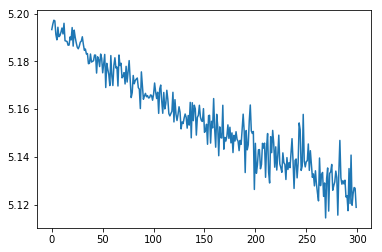

In [25]:
g = G
heads = 1
hidden_dim = 50
hidden_dim1 = 50
out_dim = len(outputs)
mean_pool = True
epochs = 100
batchs = 3
lr = 0.001
gat_embeddings,lossses,gat_embedder = train_gat_embedder(g,heads,hidden_dim,
                                                         hidden_dim1,out_dim,mean_pool,epochs,batchs,lr)

In [26]:
compare_words("瑞士","日内瓦",gat_embeddings)

0.4999999403953552

In [28]:
get_top_similar_words("表示",gat_embeddings)

,top_5_words,scores
146,称,0.5
62,证词,0.5
132,来说,0.5
161,合作,0.5
175,手续费,0.5
